# Drive Mount Etme


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Kütüphaneleri Yükleme


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time

from sklearn.model_selection import GroupKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

# Verileri Çekme ve İçeriğini İnceleme

In [ ]:
train_dir = '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/train'
test_dir = '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/test'
train_df = pd.read_csv('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/train.csv')

In [ ]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [ ]:
train_df = train_df[train_df['class_id'] != 14].reset_index(drop=True)
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


In [ ]:
train_df['image_path'] = '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/train/'+train_df.image_id+'.png'
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...


# GroupKFold ile Çapraz Doğrulma Gerçekleştirme

In [ ]:
# Bu kod image_id'ye göre gruplama ile 5 katlı çapraz doğrulama gerçekleştirir ve train_df veri çerçevesindeki her satıra karşılık gelen kat sayısını atar.
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,4


In [ ]:
# Fold sütunundaki değerler göre gruplandırma.
train_df.groupby('fold')['image_id'].agg(lambda x: x.nunique()).reset_index()

,fold,image_id
0,0,879
1,1,879
2,2,879
3,3,878
4,4,879


# Ön İşlemler


In [ ]:
# x/y_min, x/y_max ve width height değerlerini kullanarak 512x512'lik piksellik sabit bir görüntü boyutuna ölçeklendirme.
IMG_SIZE = 512
train_df['xmin'] = (train_df['x_min']/train_df['width'])*IMG_SIZE
train_df['ymin'] = (train_df['y_min']/train_df['height'])*IMG_SIZE
train_df['xmax'] = (train_df['x_max']/train_df['width'])*IMG_SIZE
train_df['ymax'] = (train_df['y_max']/train_df['height'])*IMG_SIZE

In [ ]:
# Yukarıdaki adımın doğru olup olmadığını kontrol etme
assert train_df['xmin'].all() <= IMG_SIZE
assert train_df['ymin'].all() <= IMG_SIZE
assert train_df['xmax'].all() <= IMG_SIZE
assert train_df['ymax'].all() <= IMG_SIZE   

In [ ]:
train_df[train_df['image_id'] == '9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,fold,xmin,ymin,xmax,ymax
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,170.092308,301.369863,406.892308,401.315068
2899,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,440.369231,378.958904,461.538462,436.602740
13222,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,440.369231,378.958904,461.538462,436.602740
13809,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,170.338462,301.369863,407.876923,394.301370
22621,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,169.600000,287.780822,410.092308,386.410959
28361,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,3,258.953846,156.712329,319.753846,211.726027


## Sınıf İsimlerini Gösterme


In [ ]:
class_dict = dict(set(zip(train_df.class_id, train_df.class_name)))
classes = []
for key in sorted(class_dict.keys()): 
    classes.append(class_dict[key])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [ ]:
# Verileri Yüklemek ve Önceen işlemek için kullanılan PyTorch veri kümesi sınıfı oluşturma.
class VBDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None): 
        # Bu fonk. benzersiz görüntü kimliklerini DataFrame'den çıkararak ve bunları image_ids özniteliğine kaydederek veri kümesini başlatır
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        # Veri kümesinden bir görüntü geldiğinde DataFrame'den image_id gibi gerekli açıklamalar alınır.
        # OpenCV ile görüntüyü yükler, RGB formatına dünüştürür, piksel değerlerini normalleştirir[0,1] ve kaydeder.
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # Arka plana uyum sağlamak için tüm etiketler 1 kaydırılır
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
        
        # örneklerin hiçbirinin kalabalık olmadığını belirtmek için 0 olarak ayarlanır.
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {} #sınırlayıcı kutu koordinatları, sınıf etiketleri, görüntü kimliği, alan ve kalabalık durumu dahil olmak üzere her görüntü için yer gerçeği ek açıklamalarını depolamak için kullanılır
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
      # image_ids özniteliğindeki benzersiz görüntü kimliklerinin sayısına eşit olan veri kümesindeki görüntü sayısını döndürür
        return self.image_ids.shape[0]

In [ ]:
# train_df ve train_dir(veriler) kullanarak örnek bir deneme
dt = VBDDataset(train_df, train_dir)
dt[0]

<ipython-input-13-0400dadf0d70>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))


(array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.44705883, 0.44705883, 0.44705883],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.2901961 , 0.2901961 , 0.2901961 ],
         [0.30980393, 0.30980393, 0.30980

# Augmentation(Veri artırma) ve Albumentations(Tensöre dönüştürme) 

In [ ]:
# Augmentation
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(rotate_limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Albumentations
def get_valid_transform():
    return A.Compose([
        A.ShiftScaleRotate(rotate_limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Faster-RCNN Modelini Yükleme


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 15 

# Sınıflandırıcı için giriş özelliklerinin sayısını alma
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Önceden eğitilmiş başlığı yenisiyle değiştirme
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Ortalamayı takip etmek için kullanılacak sınıf
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# Nesne algılama görevi için eğitim ve doğrulama veri kümelerini yüklemek ve yinelemek için PyTorch DataLoader nesneleri oluşturmada kullanılacak sınıf.
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(train_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(train_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Örnek bir resim


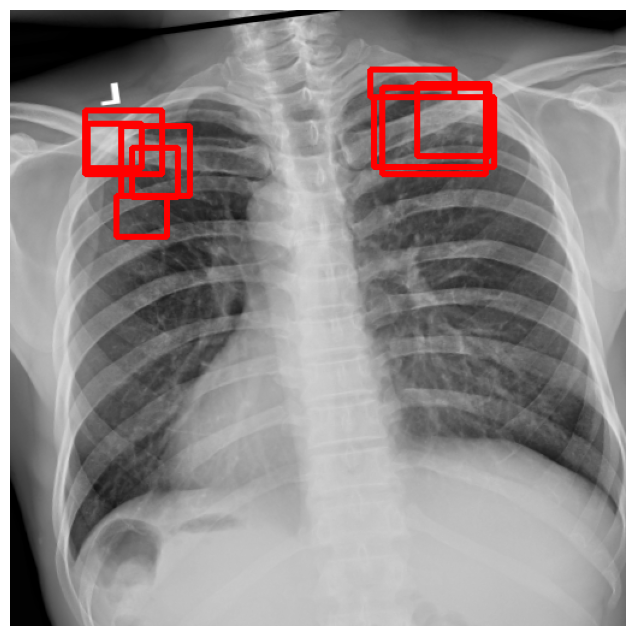

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Modeli Eğitme

In [ ]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())


    train_data_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader



def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1
        
        # saving the model based on training loss for now. - later can be moved to validation
        #if loss_hist.value < best_loss:
         #   best_loss = loss_hist.value
          #  torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses
        
        
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(train_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold) 
    
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)
    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = None

epochs = 20

num_folds = 1

In [ ]:
for fold in range(num_folds):
    run_fold(fold)

Starting fold 0
